In [1]:
from netgen.geom2d import SplineGeometry
from ngsolve import *
from netgen.geom2d import CSG2d, Circle, Rectangle
from matplotlib import pyplot as plt
from ngsolve.webgui import Draw

# Create a 2D geometry for the mesh
def create_geometry(W,H,w_solid,h_solid,pos_x_solid,pos_y_solid,order,maxh=0.05):
    geo = CSG2d()
    fluid = Rectangle(pmin=(0,0), pmax=(W,H), mat="fluid", left="inlet", top="wall", bottom="wall", right="outlet")
    solid = Rectangle(pmin=(pos_x_solid,pos_y_solid), pmax=(pos_x_solid+w_solid,pos_y_solid+h_solid), mat="solid", left="solid_left", top="solid_top", bottom="solid_bottom", right="solid_right")
    domain_fluid = fluid - solid
    domain_solid = solid
    geo.Add(domain_fluid)
    geo.Add(domain_solid)
    # generate mesh
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(order)
    
    return mesh

# Parameters
W = 4.0  # Width of the fluid domain
H = 1.0  # Height of the fluid domain
w_solid = 0.1  # Width of the solid block
h_solid = 0.5  # Height of the solid block
pos_x_solid = 1.8  # X position of the solid block
pos_y_solid = 0.0  # Y position of the solid block
order = 3  # Polynomial order for the mesh
maxh = 0.05  # Maximum mesh size
tip_point_left_x = pos_x_solid - w_solid/2.0
tip_point_left_y = pos_y_solid + h_solid
tip_point_right_x = pos_x_solid + w_solid/2.0
tip_point_right_y = pos_y_solid + h_solid
# Create the mesh
mesh = create_geometry(W, H, w_solid, h_solid, pos_x_solid, pos_y_solid, order, maxh)
# Visualize the mesh
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

# Simulation parameters

In [2]:
# import dataclass
from dataclasses import dataclass
# (rhos, nus, mus, rhof, nuf, U) = (1e4, 0.4, 0.5*1e6, 1e3, 1e-3, 1)
@dataclass
class MateralProperties:
    rho_s: float = 1e4
    # poisson ratio of solid
    nu_s: float = 0.4
    mu_s: float = 0.5 * 1e6
    rho_f: float = 1e3
    # kinematic viscosity
    nu_f: float = 1e-3
    # dynamic viscosity
    mu_f: float = nu_f * rho_f
    U: float = 1.0
    lambda_s: float = 2 * mu_s * nu_s / (1 - 2 * nu_s)

@dataclass
class SimulationParameters:
    dt: float = 0.004
    t_end: float = 4
    theta: float = 0.5

par = Parameter(0)
uinflow = par * CoefficientFunction( (4 * MateralProperties.U * 1.5 * y * (H-y)/(H*H), 0) )

In [3]:
V = VectorH1( mesh, order = order, dirichlet = "inlet|wall")
Q = H1( mesh, order = order - 1, definedon = "fluid" )
D = VectorH1( mesh, order = order, dirichlet = "inlet|wall|outlet" )

X = V*Q*D
Y = V*Q
(u, p, d), (v, q, w) = X.TnT()

#Gridfunctions
gfu    = GridFunction(X)
gfuold = GridFunction(X)
    
#Extract variables
velocity, pressure, deformation = gfu.components
velocityold, pressureold, deformationold = gfuold.components

graduold = Grad(velocityold)
graddold = Grad(deformationold)

I = Id(mesh.dim)

def CalcStresses(A):
    F = A + I
    C = F.trans*F
    E = 0.5*(C - I)
    J = Det(F)
    Finv = Inv(F)
    return (F, C, E, J, Finv)

(F,C,E,J,Finv) = CalcStresses(Grad(d))
(Fold,Cold,Eold,Jold,Finvold) = CalcStresses(graddold)

def stress_solid(E):
    S = 2 * MateralProperties.mu_s * E + MateralProperties.lambda_s * Trace(E) * I
    return S

In [4]:
#For Stokes problem for the inital solution
stokes = BilinearForm(Y, symmetric=True)
stokes += ( 2*MateralProperties.mu_f*InnerProduct(Sym(Grad(u)),Sym(Grad(v)))
            - div(u)*q - div(v)*p - 1e-8*p*q ) * dx('fluid')
stokes.Assemble()

# rhs_stokes = u.vec.CreateVector()
# uinflow    = CoefficientFunction( (4*y*(H-y)/H**2, 0) )

# tmp = GridFunction(Y)
# tmp.components[0].Set(uinflow, definedon=mesh.Boundaries('inlet'))
# rhs_stokes.data = stokes.mat * tmp.vec

# freedofs = Y.FreeDofs() & ~Y.GetDofs(mesh.Materials('solid'))
# stokes_inv = stokes.mat.Inverse(freedofs)
# tmp.vec.data -= stokes_inv * rhs_stokes

# gfu.components[0].vec.data = tmp.components[0].vec
# gfu.components[1].vec.data = tmp.components[1].vec

truecompile=False

used dof inconsistency
(silence this warning by setting BilinearForm(...check_unused=False) )


In [5]:


theta = SimulationParameters.theta
theta_n = 1 - theta
a = BilinearForm( X, symmetric = False, check_unused=False )
########################### Fluid: Navier-Stokes ##########################
# M du/dt
a += ( MateralProperties.rho_f*InnerProduct(J*(u-velocityold), v) ).Compile(truecompile,wait=True)*dx("fluid")
# Laplace
a += ( SimulationParameters.dt * theta *   MateralProperties.mu_f*InnerProduct(J*Grad(u)*Finv, Grad(v)*Finv)\
      +SimulationParameters.dt * theta_n * MateralProperties.mu_f*InnerProduct(Jold*Sym(graduold*Finvold), (Grad(v)*Finvold)) ).Compile(truecompile,wait=True)*dx("fluid")
# Convection
a += SimulationParameters.dt * ( 
    theta * MateralProperties.rho_f * InnerProduct(J*(Grad(u)*Finv)*u, v)+
    theta_n * MateralProperties.rho_f * InnerProduct(Jold*(graduold*Finvold)*velocityold, v) ).Compile(truecompile,wait=True)*dx("fluid")
# mesh velocity
a += ( - MateralProperties.rho_f * InnerProduct((J*Grad(u)*Finv)*(d-deformationold), v) ).Compile(truecompile,wait=True)*dx("fluid")
# Pressure/Constraint
a +=  -SimulationParameters.dt * J*(Trace(Grad(v)*Finv)*p).Compile(truecompile,wait=True)*dx("fluid")
a +=   J*  (Trace(Grad(u)*Finv)*q).Compile(truecompile,wait=True)*dx("fluid")
########################### Solid: elastic wave ##########################
# M du/dt
a += ( MateralProperties.rho_s*InnerProduct(u-velocityold, v) ).Compile(truecompile,wait=True)*dx("solid")
# Material law (there should not be 2 here)
a += (SimulationParameters.dt * 
            ( theta   * InnerProduct(2*F*   stress_solid(E)   , Grad(v)) + 
              theta_n * InnerProduct(2*Fold*stress_solid(Eold), Grad(v)) )).Compile(truecompile,wait=True)*dx("solid")
#dd/dt = u
a += (-SimulationParameters.dt *
            (theta * InnerProduct(u,w) +
             theta_n * InnerProduct(velocityold,w) )).Compile(truecompile,wait=True)*dx("solid")
a += ( InnerProduct( (d-deformationold), w)).Compile(truecompile,wait=True)*dx("solid")
########################## Defextension ##########################
factor = 1e-20*MateralProperties.mu_s
# minimum of two distance values
def minCF(a,b) : return IfPos(a-b, b, a)
Vdist = H1(mesh, order=2)
gfdist = GridFunction(Vdist)
gfdist.Set( minCF( (x-tip_point_left_x)*(x-tip_point_left_x)+(y-tip_point_left_y)*(y-tip_point_left_y), 
                   (x-tip_point_right_x)*(x-tip_point_right_x)+(y-tip_point_right_y)*(y-tip_point_right_y) ) )

def NeoHookExt (C, mu=1,lam=1):
    return 0.5 * mu * (Trace(C-I) + 2*mu/lam * Det(C)**(-lam/2/mu) - 1)
a += Variation( (factor*(1/sqrt(gfdist*gfdist+1e-12)) * NeoHookExt(C)).Compile(truecompile,wait=True)*dx("fluid"))

In [6]:
bts = Y.FreeDofs() & ~Y.GetDofs(mesh.Materials("solid"))
bts &= ~Y.GetDofs(mesh.Boundaries("wall|inlet|solid_left|solid_top|solid_bottom|solid_right"))
bts[V.ndof:] = True
invstoke = stokes.mat.Inverse(bts)

# create a temperary function velocity+pressure for the fluid domain
tmp = GridFunction(Y)
# crate a empty vector
rstokes = tmp.vec.CreateVector()

# directly start with Stokes solution instead of increasing inflow
start_with_stokes = True

if start_with_stokes:
    # rstokes = A * guess
    # correction = invA * rstokes
    # u = guess - correction

    par.Set(1)
    # setting the nodes of inlet to the inflow
    tmp.components[0].Set( uinflow, definedon=mesh.Boundaries("inlet") )
    # calculating the residual r=A* u_0
    rstokes.data = stokes.mat*tmp.vec
    # correction step of solving a linear system u = u_0 - A^{-1}*r
    tmp.vec.data -= invstoke*rstokes
    gfu.components[0].vec.data = tmp.components[0].vec
    gfu.components[1].vec.data = tmp.components[1].vec
    gfuold.vec.data = gfu.vec
    
w = gfu.vec.CreateVector()
r = GridFunction(X)
    
disp_x = []
disp_y = []

def CalcForces():
    dmidx = gfu.components[2](pos_x_solid + w_solid/2.0,pos_y_solid+h_solid)[0]
    dmidy = gfu.components[2](pos_x_solid + w_solid/2.0,pos_y_solid+h_solid)[1]
    disp_x.append( dmidx )
    disp_y.append( dmidy )
    return

t = 0
CalcForces()

sceneu = Draw(mesh.MaterialCF( {"fluid" :velocity}, default=None), mesh,\
              "velocity", deformation=deformation, order=3)
scenep = Draw(pressure, mesh, "pressure", deformation=deformation)
scened = Draw(deformation, mesh, "deformation")

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [7]:
i = 0
times = [0]
vtk_velocity = VTKOutput(ma=mesh, coefs=[gfu.components[0]], names=["velocity"], filename="results/fsi_new/velocity_solution", subdivision=0)
vtk_pressure = VTKOutput(ma=mesh, coefs=[gfu.components[1]], names=["pressure"], filename="results/fsi_new/pressure_solution", subdivision=0)
vtk_deformation = VTKOutput(ma=mesh, coefs=[gfu.components[2]], names=["deformation"], filename="results/fsi_new/deformation_solution", subdivision=0)
vtk_velocity.Do()
vtk_pressure.Do()
vtk_deformation.Do()

# while t < SimulationParameters.t_end-SimulationParameters.dt/2.0:
while t < 0.74:
    t += SimulationParameters.dt
    print ("\rt=", t, end="")
    times.append(t)

        
    #Newton's method
    for it in range(10):
        a.Apply(gfu.vec, r.vec)
        a.AssembleLinearization(gfu.vec)
        inv = a.mat.Inverse(X.FreeDofs())
                
        w.data = inv*r.vec
        
        err = InnerProduct(w, r.vec)
        #print("err^2 = ", err)
                        
        gfu.vec.data -= w
                
        if sqrt(abs(err)) < 1e-6: break
           
    if i %10 == 0:
        sceneu.Redraw()
        scened.Redraw()
        scenep.Redraw()
        vtk_velocity.Do()
        vtk_pressure.Do()
        vtk_deformation.Do()
    CalcForces()
    gfuold.vec.data = gfu.vec
    
    i += 1

t= 0.740000000000000576

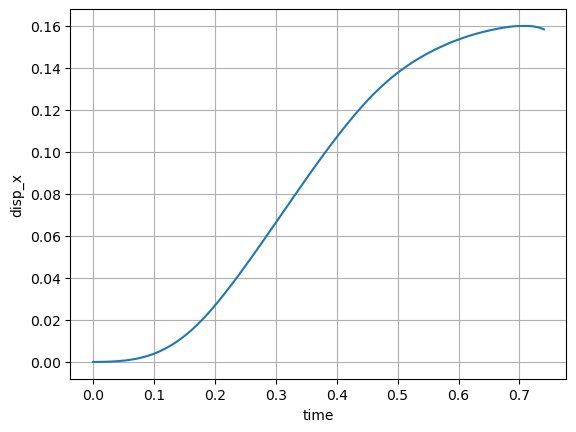

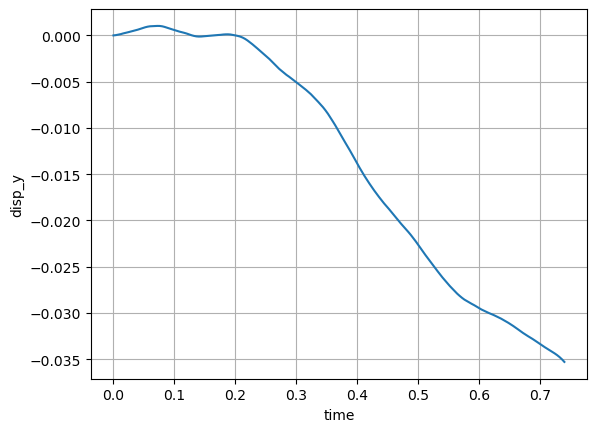

In [8]:
import matplotlib; import numpy as np; import matplotlib.pyplot as plt; 
%matplotlib inline  

# times = times[:-1]
plt.plot(times, disp_x)
plt.xlabel('time'); plt.ylabel('disp_x'); plt.grid(True)
plt.show()   

plt.plot(times, disp_y)
plt.xlabel('time'); plt.ylabel('disp_y'); plt.grid(True)
plt.show()   